In [1]:
## Use this instead if you want to use the codes inside the src folder.
%load_ext autoreload
%autoreload 2
from src.color_code_stim.color_code import ColorCode

# ColorCode object and its attributes

## Initialization of a ColorCode object

Currently support only the logical idling gate of a triangular color code, which is preceded by a logical-$Z$ initialization (to its $+1$ eigenstate) and followed by a logical-$Z$ measurement.

ex) 5-round idling gate of distance-5 color code under circuit-level noise of strength 1e-3.

In [16]:
colorcode = ColorCode(
    d=5,
    rounds=5,
    circuit_type="tri",  # {"tri", "rec", "rec_stability", "growing", "cult+growing"}
    cnot_schedule="tri_optimal",  # Default CNOT schedule optimized in our paper.
    p_circuit=1e-3,
)

## Tanner graph of the code

In [6]:
graph = colorcode.tanner_graph  # igraph.Graph object
print("Total number of vertices:", len(graph.vs))
print("Total number of edges:", len(graph.es))
print()
print("Some examples of vertices:")
for v in graph.vs[:10]:
    print(v)

Total number of vertices: 37
Total number of edges: 111

Some examples of vertices:
igraph.Vertex(<igraph.Graph object at 0x17372c450>, 0, {'x': 0, 'y': 0, 'qid': 0, 'pauli': None, 'color': None, 'obs': True, 'boundary': 'rg', 'name': '0-0'})
igraph.Vertex(<igraph.Graph object at 0x17372c450>, 1, {'x': 2, 'y': 0, 'qid': 1, 'pauli': None, 'color': None, 'obs': True, 'boundary': 'r', 'name': '2-0'})
igraph.Vertex(<igraph.Graph object at 0x17372c450>, 2, {'x': 4, 'y': 0, 'qid': 2, 'pauli': 'Z', 'color': 'g', 'obs': False, 'boundary': 'r', 'name': '4-0-Z'})
igraph.Vertex(<igraph.Graph object at 0x17372c450>, 3, {'x': 4, 'y': 0, 'qid': 3, 'pauli': 'X', 'color': 'g', 'obs': False, 'boundary': 'r', 'name': '4-0-X'})
igraph.Vertex(<igraph.Graph object at 0x17372c450>, 4, {'x': 6, 'y': 0, 'qid': 4, 'pauli': None, 'color': None, 'obs': True, 'boundary': 'r', 'name': '6-0'})
igraph.Vertex(<igraph.Graph object at 0x17372c450>, 5, {'x': 8, 'y': 0, 'qid': 5, 'pauli': None, 'color': None, 'obs': True

## Circuit

In [7]:
circuit = colorcode.circuit  # stim.Circuit object

## Detectors

Detectors have their own detector IDs.

A detector is specified by the round (integer) it belongs to and the ancillary qubit (igraph.Vertex) involved in it.

In [8]:
num_detectors = colorcode.circuit.num_detectors
print("Number of detectors:", num_detectors)
print("Some examples of detectors:")
for det_id in range(0, num_detectors, 10):
    anc, rnd = colorcode.get_detector(det_id)
    print(f"id = {det_id}: round {rnd}, ancillary qubit {anc}")

Number of detectors: 90
Some examples of detectors:
id = 0: round 0, ancillary qubit igraph.Vertex(<igraph.Graph object at 0x17372c450>, 2, {'x': 4, 'y': 0, 'qid': 2, 'pauli': 'Z', 'color': 'g', 'obs': False, 'boundary': 'r', 'name': '4-0-Z'})
id = 10: round 1, ancillary qubit igraph.Vertex(<igraph.Graph object at 0x17372c450>, 6, {'x': 10, 'y': 0, 'qid': 6, 'pauli': 'Z', 'color': 'g', 'obs': False, 'boundary': 'r', 'name': '10-0-Z'})
id = 20: round 1, ancillary qubit igraph.Vertex(<igraph.Graph object at 0x17372c450>, 10, {'x': 1, 'y': 1, 'qid': 10, 'pauli': 'X', 'color': 'b', 'obs': False, 'boundary': 'g', 'name': '1-1-X'})
id = 30: round 2, ancillary qubit igraph.Vertex(<igraph.Graph object at 0x17372c450>, 13, {'x': 7, 'y': 1, 'qid': 13, 'pauli': 'Z', 'color': 'b', 'obs': False, 'boundary': None, 'name': '7-1-Z'})
id = 40: round 2, ancillary qubit igraph.Vertex(<igraph.Graph object at 0x17372c450>, 19, {'x': 4, 'y': 2, 'qid': 19, 'pauli': 'X', 'color': 'r', 'obs': False, 'boundary'

# Sampling & Decoding with the Concatenated MWPM decoder

## Shortcut: sampling & decoding & stats at once

In [24]:
colorcode = ColorCode(
    d=5,
    rounds=5,
    cnot_schedule="tri_optimal",  # Default CNOT schedule optimized in our paper.
    p_circuit=1e-3,
)

In [25]:
alpha = 0.01
num_fails, info = colorcode.simulate(
    10000,  # Number of shots
    full_output=True,  # Whether to get additional information on decoding outputs
    alpha=alpha,  # Significance level of the confidence interval of pfail
    verbose=True,
    seed=42,
)

Sampling...
Decoding...
First-round decoding:
    > logical class 0, color r...
    > logical class 0, color g...
    > logical class 0, color b...
Second-round decoding:
    > logical class 0, color r...
    > logical class 0, color g...
    > logical class 0, color b...
Postprocessing...


In [26]:
info

{'best_colors': array([1, 0, 0, ..., 0, 0, 0]),
 'weights': array([10.6798557 , 10.00874642,  0.        , ...,  0.        ,
        24.42594793,  0.        ]),
 'error_preds': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'stats': (0.0038292041926628094, 0.0015559328739831032),
 'fails': array([False, False, False, ..., False, False, False])}

In [27]:
print("Number of failures =", num_fails)
pfail, delta_pfail = info["stats"]
print(
    f"pfail = {pfail:.2e} +- {delta_pfail:.2e} ({(1 - alpha) * 100}% confidence interval)"
)

Number of failures = 35
pfail = 3.83e-03 +- 1.56e-03 (99.0% confidence interval)


## Step-by-step

### Sampling detector and observable outcomes

In [28]:
det, obs = colorcode.sample(10000, seed=42)

`det[i,j]` is `True` if and only if the detector with id `j` in the `i`th sample has an outcome of $-1$.

In [29]:
det

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

`obs[i]` is `True` if and only if the logical observable of the `i`th sample has an outcome of $-1$.

In [30]:
obs

array([False, False, False, ..., False, False, False])

### Decode using the concatenated MWPM decoder

In [31]:
preds_obs, info = colorcode.decode(det, verbose=True, full_output=True)

First-round decoding:
    > logical class 0, color r...
    > logical class 0, color g...
    > logical class 0, color b...
Second-round decoding:
    > logical class 0, color r...
    > logical class 0, color g...
    > logical class 0, color b...


In [32]:
preds_obs  # Predictions of logical observables

array([False, False, False, ..., False, False, False])

In [33]:
list(info.keys())

['best_colors', 'weights', 'error_preds']

In [35]:
info["best_colors"]  # Selected best colors (0: red, 1: green, 2: blue)

array([1, 0, 0, ..., 0, 0, 0])

In [36]:
info["weights"]  # Log-likelihood ratio weights of predictions

array([10.6798557 , 10.00874642,  0.        , ...,  0.        ,
       24.42594793,  0.        ])

**Check failures**

In [38]:
import numpy as np

fails = np.logical_xor(obs, preds_obs)
fails

array([False, False, False, ..., False, False, False])

In [39]:
print("Number of failures:", np.sum(fails))

Number of failures: 35


# Visualization

## Tanner graph & Lattice

<Axes: >

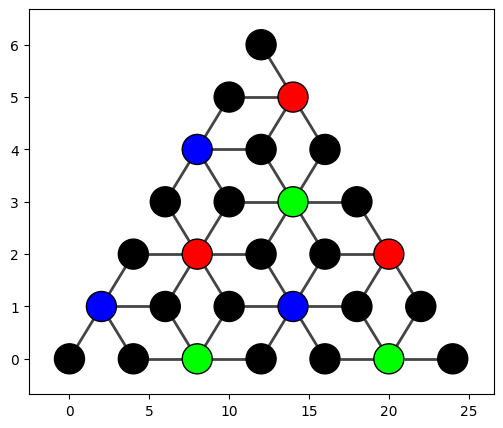

In [42]:
# qubits: black, checks: red/green/blue
# For simplicity, only one of the two checks of each face is visible.

colorcode = ColorCode(d=5, rounds=1, circuit_type="tri", p_bitflip=1e-2)
colorcode.draw_tanner_graph(show_axes=True)

<Axes: >

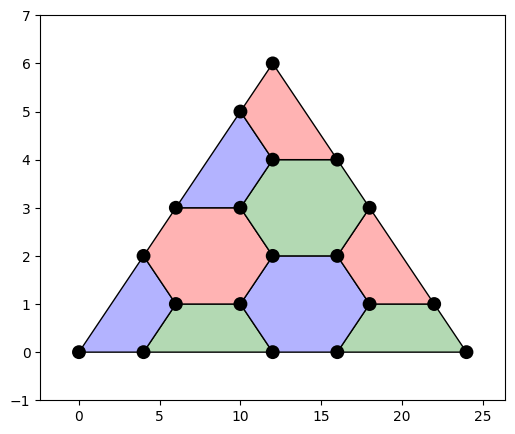

In [43]:
colorcode.draw_lattice(show_axes=True)

## Errors on the lattice

Only supported for `circuit_type="tri"` and `circuit_type="rec"` with `rounds=1` under bit-flip noise.

In [7]:
import numpy as np

colorcode = ColorCode(d=7, rounds=1, circuit_type="tri", p_bitflip=2e-2)

det, obs, err = colorcode.sample_with_errors(shots=10000, seed=42)
pred, extra_outputs = colorcode.decode(
    det, full_output=True, check_validity=True, verbose=True
)
fail = obs ^ pred
failed_samples = np.nonzero(fail)[0]
print(failed_samples)

First-round decoding:
    > logical class 0, color r...
    > logical class 0, color g...
    > logical class 0, color b...
Second-round decoding:
    > logical class 0, color r...
    > logical class 0, color g...
    > logical class 0, color b...
All predictions are valid
[ 807 1540 2524 2773 7909 8227 8381]


In [8]:
idx = failed_samples[1]
err_qubits = colorcode.errors_to_qubits(err[idx])
corr_qubits = colorcode.errors_to_qubits(extra_outputs["error_preds"][idx])
err_qubits = np.nonzero(err_qubits)[0]
corr_qubits = np.nonzero(corr_qubits)[0]
violated_faces = np.nonzero(det[idx])[0]
print("Qubits with bit-flip errors:", err_qubits)
print("Prediction (failed):", corr_qubits)
print("Faces with violated stabilizers:", violated_faces)

Qubits with bit-flip errors: [12 17 29 31]
Prediction (failed): [ 5 25 30]
Faces with violated stabilizers: [ 2  5 10 12 13 14 16]


<Axes: >

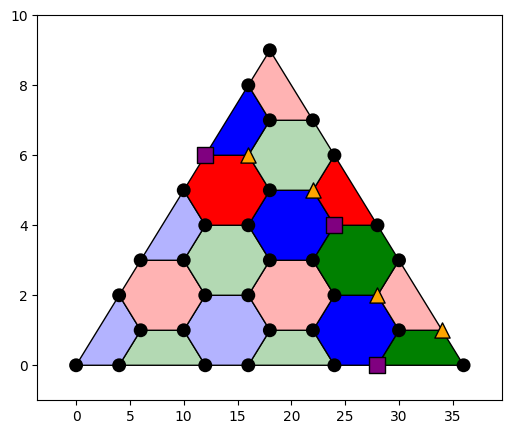

In [9]:
colorcode.draw_lattice(
    show_axes=True,
    highlight_qubits=err_qubits,  # orange triangles
    highlight_qubits2=corr_qubits,  # purple rectangles
    highlight_faces=violated_faces,  # dark faces
)